## Casual Analysis of Risk factors associated with depression

In [606]:
import numpy as np
import pandas as pd

import os
from functools import reduce  

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import random
from prettytable import PrettyTable

## Load Data

In [607]:
RANDOM_SEED = 2432

# full data
full_data = pd.DataFrame()

# from each file
for filename in os.listdir('data'):
    if(filename.endswith(".XPT")):
        file = os.path.join('data', filename)
        newcols = pd.read_sas(file, encoding='UTF-8')
        
        if(len(full_data) == 0):
            full_data = newcols
        else:
            full_data = pd.merge(full_data, newcols, on = "SEQN", how = "outer")

#in case we want the file in csv
# full_data.to_csv('data/data_combined.csv')

print(full_data.shape)

(9254, 310)


**3344** rows with values 

In [608]:
cols = full_data.loc[:,"DPQ010":"DPQ090"].columns
valid = full_data.copy()
valid[cols] = valid[cols].round()

# only care about values 0-3

# TODO: FIX THIS, REMOVES ROWS THAT CONTAIN EVEN a single value above 3
for i in range(len(cols)):
    valid = valid.loc[valid[cols[i]] <=3]
    
# for i in range(len(cols)):
#     valid[cols[i]] = valid.loc[valid[cols[i]] > 3, cols[i]]

# sum_dp
valid["sum_DPQ"] = valid[cols].sum(axis="columns", skipna = True)
print(valid.shape)
# valid.describe()

(5068, 311)


In [609]:
valid

,SEQN,ALQ111,ALQ121,ALQ130,ALQ142,ALQ270,ALQ280,ALQ290,ALQ151,ALQ170,...,WHD080L,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ190,WHQ200,sum_DPQ
0,93705.0,1.0,7.000000e+00,1.0,5.397605e-79,NaN,NaN,NaN,2.0,5.000000e+00,...,NaN,4.0,150.0,130.0,63.0,170.0,62.0,2.0,NaN,0.0
1,93706.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,150.0,17.0,2.0,NaN,0.0
2,93708.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,118.0,100.0,60.0,120.0,40.0,2.0,NaN,0.0
4,93711.0,1.0,5.000000e+00,1.0,5.397605e-79,NaN,NaN,NaN,2.0,5.397605e-79,...,NaN,5.0,142.0,148.0,69.0,152.0,33.0,2.0,NaN,2.0
5,93712.0,1.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,5.0,NaN,NaN,NaN,137.0,17.0,2.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5528,102949.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,180.0,NaN,180.0,33.0,2.0,NaN,0.0
5529,102952.0,1.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,5.0,117.0,120.0,NaN,120.0,23.0,2.0,NaN,0.0
5530,102953.0,1.0,6.000000e+00,12.0,6.000000e+00,5.397605e-79,6.000000e+00,5.397605e-79,2.0,5.397605e-79,...,NaN,5.0,200.0,180.0,NaN,222.0,41.0,2.0,NaN,3.0
5531,102954.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,145.0,120.0,NaN,180.0,38.0,2.0,NaN,0.0


In [610]:
# chosen variables, SEQN removed
# features = ['SEQN','RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ',
#             'INDHHIN2', 'BMXBMI', 'URXUAS', 'URXUHG', 'ALQ130', 'DUQ217', 'FSD230', 'INDFMMPI',
#             'PAD680', 'OCQ180', 'OCQ210', 'SMQ040', 'SMD650', 'SLD012', 'sum_DPQ']

features = ['SEQN','RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ',
            'INDHHIN2','INDFMIN2', 'BMXBMI', 'URXUAS', 'URXUHG', 'ALQ130', 'DUQ217', 'FSD230', 'INDFMMPI',
            'PAD680', 'OCQ180', 'OCQ210', 'SMQ040', 'SMD650', 'SLD012', 'FIAINTRP', 'FIAPROXY', 'FSD032A', 
            'FSD032B', 'FSD032C', 'FSD061', 'HUQ051', 'HUQ090', 'PAD615','SLQ050','OCQ380', 'PAD630', 'PAD660', 'SLQ120','sum_DPQ']

subdata = full_data.filter(items = features)
subdata = subdata[subdata.RIDAGEYR >= 18]
subdata_features = subdata.filter(items=['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ',
            'INDHHIN2','INDFMIN2', 'BMXBMI', 'URXUAS', 'URXUHG', 'ALQ130', 'DUQ217', 'FSD230', 'INDFMMPI',
            'PAD680', 'OCQ180', 'OCQ210', 'SMQ040', 'SMD650', 'SLD012', 'FIAINTRP', 'FIAPROXY', 'FSD032A', 
            'FSD032B', 'FSD032C', 'FSD061', 'HUQ051', 'HUQ090', 'PAD615','SLQ050','OCQ380', 'PAD630', 'PAD660', 'SLQ120'])

In [611]:
# percentage null values 
nullvals = (subdata.isnull().mean() * 100).round(2)
# pretty_table = PrettyTable()
# pretty_table.add_column("Variable", nullvals.index) 
# pretty_table.add_column("Percent NA", nullvals.values) 

# print(pretty_table)
# subdata.info()

nullvals

SEQN         0.00
RIAGENDR     0.00
RIDAGEYR     0.00
RIDRETH1     0.00
DMDCITZN     0.05
DMDEDUC2     4.90
DMDHHSIZ     0.00
INDHHIN2     5.96
INDFMIN2     5.70
BMXBMI       7.21
URXUAS      69.26
URXUHG      69.18
ALQ130      40.32
DUQ217      85.18
FSD230      77.89
INDFMMPI    20.54
PAD680       0.17
OCQ180      47.56
OCQ210      83.81
SMQ040      59.72
SMD650      82.79
SLD012       0.80
FIAINTRP     5.70
FIAPROXY     5.70
FSD032A      5.55
FSD032B      5.55
FSD032C      5.55
FSD061      65.45
HUQ051       0.00
HUQ090       0.00
PAD615      76.42
SLQ050       0.00
OCQ380      58.45
PAD630      58.57
PAD660      75.56
SLQ120       0.00
dtype: float64

In [612]:
to_convert = ['RIAGENDR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ', 'INDHHIN2', 'INDFMIN2',
              'FSD230', 'OCQ380', 'OCQ210','SMQ040', 'FIAINTRP', 'FIAPROXY', 'FSD032A', 'FSD061', 'HUQ051', 'HUQ090', 'PAD615', 'PAD630', 'PAD660', 'PAD680', 'SLQ120']

subdata[to_convert] = subdata[to_convert].astype('category')
subdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 9253
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   SEQN      5856 non-null   float64 
 1   RIAGENDR  5856 non-null   category
 2   RIDAGEYR  5856 non-null   float64 
 3   RIDRETH1  5856 non-null   category
 4   DMDCITZN  5853 non-null   category
 5   DMDEDUC2  5569 non-null   category
 6   DMDHHSIZ  5856 non-null   category
 7   INDHHIN2  5507 non-null   category
 8   INDFMIN2  5522 non-null   category
 9   BMXBMI    5434 non-null   float64 
 10  URXUAS    1800 non-null   float64 
 11  URXUHG    1805 non-null   float64 
 12  ALQ130    3495 non-null   float64 
 13  DUQ217    868 non-null    float64 
 14  FSD230    1295 non-null   category
 15  INDFMMPI  4653 non-null   float64 
 16  PAD680    5846 non-null   category
 17  OCQ180    3071 non-null   float64 
 18  OCQ210    948 non-null    category
 19  SMQ040    2359 non-null   category
 20  SMD650  

In [613]:
subdata.shape

(5856, 36)

In [614]:
# left join rows with sum_DPQ != null with subdata

valid = valid[features]
valid.columns

sample = pd.merge(valid, subdata, how = "left")
sample

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDHHSIZ,INDHHIN2,INDFMIN2,BMXBMI,...,FSD061,HUQ051,HUQ090,PAD615,SLQ050,OCQ380,PAD630,PAD660,SLQ120,sum_DPQ
0,93705.0,2.0,66.0,4.0,1.0,2.0,1.0,3.0,3.0,31.7,...,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,0.0,0.0
1,93706.0,1.0,18.0,5.0,1.0,NaN,5.0,NaN,NaN,21.5,...,NaN,2.0,2.0,NaN,2.0,2.0,NaN,NaN,1.0,0.0
2,93708.0,2.0,66.0,5.0,1.0,1.0,2.0,6.0,6.0,23.7,...,2.0,3.0,2.0,NaN,2.0,4.0,NaN,NaN,2.0,0.0
3,93711.0,1.0,56.0,5.0,1.0,5.0,3.0,15.0,15.0,21.3,...,NaN,3.0,2.0,NaN,1.0,NaN,NaN,60.0,3.0,2.0
4,93712.0,1.0,18.0,1.0,2.0,NaN,4.0,4.0,4.0,19.7,...,2.0,1.0,1.0,420.0,2.0,NaN,180.0,45.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5063,102949.0,1.0,33.0,3.0,1.0,3.0,5.0,6.0,6.0,23.7,...,1.0,1.0,2.0,90.0,2.0,NaN,300.0,NaN,2.0,0.0
5064,102952.0,2.0,70.0,5.0,1.0,3.0,2.0,4.0,4.0,20.0,...,1.0,2.0,2.0,NaN,2.0,3.0,NaN,NaN,0.0,0.0
5065,102953.0,1.0,42.0,1.0,2.0,3.0,1.0,12.0,12.0,35.8,...,2.0,6.0,2.0,240.0,1.0,NaN,240.0,NaN,2.0,3.0
5066,102954.0,2.0,41.0,4.0,1.0,5.0,7.0,10.0,10.0,26.1,...,2.0,3.0,2.0,NaN,2.0,NaN,NaN,NaN,1.0,0.0


In [615]:
# sample.loc[sample["sum_DPQ"] > 0]

## Clean Data

### n = 3344 original


In [616]:
## clean

# sample = sample.loc[sample["DMDCITZN"].notna()]
# sample = sample.loc[sample["BMXBMI"].notna()]
# sample = sample.loc[sample["PAD680"].notna()]
# sample.loc[sample.notna()]

# get columns with missing 20% or less values
columns_mostly_complete = sample.columns[(valid.isnull().mean() * 100)  <= 10]

sample = sample.loc[:, columns_mostly_complete.values]
sample = sample.dropna(axis = "rows")
sample.columns

Index(['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2',
       'DMDHHSIZ', 'INDHHIN2', 'INDFMIN2', 'BMXBMI', 'PAD680', 'SLD012',
       'FIAINTRP', 'FIAPROXY', 'FSD032A', 'FSD032B', 'FSD032C', 'HUQ051',
       'HUQ090', 'SLQ050', 'SLQ120', 'sum_DPQ'],
      dtype='object')

### Feature selection

In [617]:
sample.isnull().mean() * 100

SEQN        0.0
RIAGENDR    0.0
RIDAGEYR    0.0
RIDRETH1    0.0
DMDCITZN    0.0
DMDEDUC2    0.0
DMDHHSIZ    0.0
INDHHIN2    0.0
INDFMIN2    0.0
BMXBMI      0.0
PAD680      0.0
SLD012      0.0
FIAINTRP    0.0
FIAPROXY    0.0
FSD032A     0.0
FSD032B     0.0
FSD032C     0.0
HUQ051      0.0
HUQ090      0.0
SLQ050      0.0
SLQ120      0.0
sum_DPQ     0.0
dtype: float64

In [618]:

X = sample.loc[:, ~sample.columns.isin(['SEQN','sum_DPQ'])]
y = sample.loc[:, ['sum_DPQ']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = RANDOM_SEED)

linearmodel = LinearRegression(normalize=True)

# sfs = SequentialFeatureSelector(linearmodel, direction = "backward", cv = 5, n_features_to_select = 8)
sfs = SequentialFeatureSelector(linearmodel, direction = "backward", cv = 5)
sfs = sfs.fit(X, y)

# final selected features
backward_selected_features = X_train.columns.values[sfs.get_support()]
backward_selected_features

array(['RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'DMDHHSIZ', 'PAD680',
       'FSD032A', 'FSD032C', 'HUQ090', 'SLQ050', 'SLQ120'], dtype=object)

In [619]:
len(features)

37

# Fit linear regression

## with all features



In [620]:
X = sample.loc[:, ~sample.columns.isin(['SEQN','sum_DPQ'])]
y = sample.loc[:, ['sum_DPQ']]

# check shapes
# print(X.shape)
# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = RANDOM_SEED)

linear_model = LinearRegression(normalize = True)
linear_model = linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

# r2 = linear_model.score(X_test, y_test)
r2 = r2_score(y_test, y_pred)

MSE = mean_squared_error(y_test, y_pred)
print(f'MSE (LM Backwards selected features): {MSE}\nr-squared: {r2}\nrmse: {np.sqrt(MSE)}')

(4503, 20)
(4503, 1)
MSE (LM Backwards selected features): 12.731321108826807
r-squared: 0.2762262315474966
rmse: 3.568097687679922


Text(0, 0.5, 'pred values')

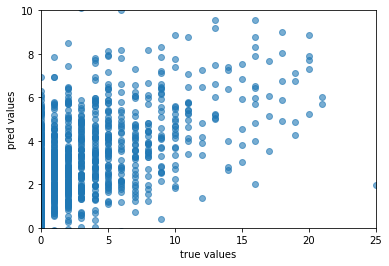

In [621]:
linear_model
plt.scatter(y_test, y_pred, alpha = 0.6)
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.xlabel("true values")
plt.ylabel("pred values")

## with selected features

In [622]:
X = sample.loc[:, sample.columns.isin(backward_selected_features)]
y = sample.loc[:, ['sum_DPQ']]

# check shapes
# print(X.shape)
# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = RANDOM_SEED)

linear_model = LinearRegression(normalize = True)
linear_model = linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

# r2 = linear_model.score(X_test, y_test)
r2 = r2_score(y_test, y_pred)

MSE = mean_squared_error(y_test, y_pred)
print(f'MSE (LM Backwards selected features): {MSE}\nr-squared: {r2}\nrmse: {np.sqrt(MSE)}')

MSE (LM Backwards selected features): 12.839235354816417
r-squared: 0.2784543694121012
rmse: 3.5831878760143763


10

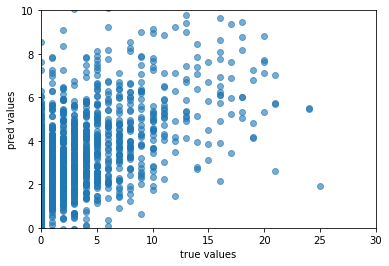

In [623]:
linear_model
intercept = linear_model.intercept_
plt.scatter(x = y_test, y = y_pred, alpha = 0.6)
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.xlabel("true values")
plt.ylabel("pred values")
linear_model.coef_.size

In [624]:
y_test.where(y_test > 5)

,sum_DPQ
631,NaN
1463,NaN
348,NaN
1119,NaN
1598,NaN
...,...
4926,8.0
2929,10.0
1612,NaN
4671,NaN


In [625]:
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(test_features)

print(sample.loc[sample["sum_DPQ"].between(0,27/2)].shape)
print(sample.loc[sample["sum_DPQ"].between(27/2,28)].shape)

(4337, 22)
(166, 22)


In [626]:
dict(sample.dtypes)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4503 entries, 0 to 5067
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      4503 non-null   float64
 1   RIAGENDR  4503 non-null   object 
 2   RIDAGEYR  4503 non-null   float64
 3   RIDRETH1  4503 non-null   object 
 4   DMDCITZN  4503 non-null   object 
 5   DMDEDUC2  4503 non-null   object 
 6   DMDHHSIZ  4503 non-null   object 
 7   INDHHIN2  4503 non-null   object 
 8   INDFMIN2  4503 non-null   object 
 9   BMXBMI    4503 non-null   float64
 10  PAD680    4503 non-null   object 
 11  SLD012    4503 non-null   float64
 12  FIAINTRP  4503 non-null   object 
 13  FIAPROXY  4503 non-null   object 
 14  FSD032A   4503 non-null   object 
 15  FSD032B   4503 non-null   float64
 16  FSD032C   4503 non-null   float64
 17  HUQ051    4503 non-null   object 
 18  HUQ090    4503 non-null   object 
 19  SLQ050    4503 non-null   float64
 20  SLQ120    4503 non-null   obje

# One hot Encoding sample DF

In [627]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(sample[['RIAGENDR']]).toarray())
encoder.categories

'auto'

In [628]:
subdata.loc[subdata["PAD680"].isnull()]

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDHHSIZ,INDHHIN2,INDFMIN2,BMXBMI,...,FSD032C,FSD061,HUQ051,HUQ090,PAD615,SLQ050,OCQ380,PAD630,PAD660,SLQ120
369,94281.0,2.0,31.0,5.0,1.0,3.0,4.0,2.0,2.0,39.5,...,3.0,2.0,8.000000e+00,2.0,NaN,2.0,1.0,NaN,NaN,4.000000e+00
501,94486.0,2.0,44.0,4.0,1.0,4.0,2.0,3.0,3.0,31.2,...,3.0,NaN,2.000000e+00,1.0,NaN,1.0,6.0,NaN,NaN,3.000000e+00
949,95231.0,1.0,32.0,5.0,1.0,2.0,5.0,8.0,8.0,28.7,...,3.0,NaN,5.397605e-79,2.0,NaN,2.0,NaN,NaN,NaN,3.000000e+00
1474,96100.0,1.0,65.0,5.0,1.0,1.0,1.0,12.0,12.0,23.1,...,3.0,NaN,2.000000e+00,1.0,NaN,1.0,4.0,NaN,NaN,4.000000e+00
2061,97054.0,1.0,40.0,3.0,1.0,2.0,3.0,6.0,6.0,28.5,...,3.0,2.0,2.000000e+00,2.0,NaN,2.0,NaN,NaN,NaN,5.397605e-79
2129,97157.0,1.0,23.0,1.0,1.0,3.0,3.0,NaN,NaN,20.7,...,NaN,NaN,8.000000e+00,1.0,NaN,1.0,NaN,NaN,NaN,4.000000e+00
2302,97445.0,1.0,51.0,4.0,1.0,3.0,1.0,4.0,4.0,30.4,...,3.0,2.0,8.000000e+00,1.0,NaN,1.0,3.0,NaN,NaN,5.397605e-79
3209,98990.0,1.0,64.0,3.0,1.0,3.0,5.0,9.0,9.0,NaN,...,2.0,1.0,3.000000e+00,2.0,NaN,1.0,6.0,NaN,NaN,4.000000e+00
4523,101238.0,1.0,36.0,2.0,1.0,4.0,3.0,9.0,9.0,26.5,...,3.0,NaN,5.397605e-79,2.0,NaN,2.0,NaN,NaN,NaN,4.000000e+00
4534,101252.0,2.0,33.0,5.0,1.0,4.0,2.0,3.0,3.0,40.0,...,3.0,NaN,8.000000e+00,1.0,NaN,2.0,NaN,NaN,NaN,2.000000e+00


['RIAGENDR' 'RIDAGEYR' 'DMDEDUC2' 'DMDHHSIZ' 'PAD680' 'FSD032A' 'FSD032C'
 'HUQ090' 'SLQ050' 'SLQ120']


<AxesSubplot:>

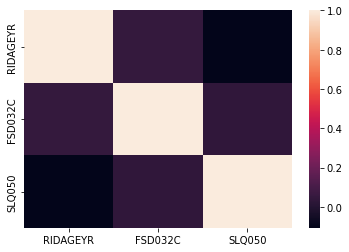

In [629]:
import seaborn as sb

corr = sample.loc[:,backward_selected_features].corr()
# sb.heatmap(corr, cmap="Blues", annot=True)

print(backward_selected_features)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)



In [630]:
sample["sum_DPQ"].value_counts()

0.0     1549
1.0      609
2.0      513
3.0      400
4.0      303
5.0      218
6.0      168
7.0      139
8.0      119
9.0      100
10.0      83
11.0      64
12.0      40
14.0      35
13.0      32
16.0      30
15.0      25
18.0      19
17.0      15
19.0      10
21.0       9
22.0       8
20.0       7
23.0       4
24.0       3
25.0       1
Name: sum_DPQ, dtype: int64

## 